In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,LSTM

C:\Users\humbe\anaconda3\envs\CVNLP\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\humbe\anaconda3\envs\CVNLP\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\humbe\anaconda3\envs\CVNLP\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\humbe\anaconda3\envs\CVNLP\lib\site-packages\tensorflow\python\f

In [4]:
# load de data
#company = 'TSLA'

start_end_year = input('Enter year period: ').split(',')
start_end_month = input('Enter month period: ').split(',')
start_end_day = input('Enter day period: ').split(',')
company = input('Enter company ID: ')

start = dt.datetime(int(start_end_year[0]),int(start_end_month[0]),int(start_end_day[0]))
end = dt.datetime(int(start_end_year[1]),int(start_end_month[1]),int(start_end_day[1]))

data = web.DataReader(company, 'yahoo', start, end)

# Prepare data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

prediction_days = 60

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x,0])

x_train,y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))

Enter year period:  2010,2021
Enter month period:  10,10
Enter day period:  20,20
Enter company ID:  BTC-USD


In [5]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['acc'])

In [6]:
model.fit(x_train, y_train, epochs=25, batch_size=32, validation_split=0.1)

Train on 2268 samples, validate on 253 samples
Epoch 1/25
2268/2268 [==============================] - 10s 5ms/step - loss: 0.0012 - acc: 4.4092e-04 - val_loss: 0.0187 - val_acc: 0.0040
Epoch 2/25
2268/2268 [==============================] - 8s 4ms/step - loss: 5.9679e-04 - acc: 4.4092e-04 - val_loss: 0.0071 - val_acc: 0.0040
Epoch 3/25
2268/2268 [==============================] - 9s 4ms/step - loss: 4.7636e-04 - acc: 4.4092e-04 - val_loss: 0.0058 - val_acc: 0.0040
Epoch 4/25
2268/2268 [==============================] - 10s 4ms/step - loss: 3.8969e-04 - acc: 4.4092e-04 - val_loss: 0.0059 - val_acc: 0.0040
Epoch 5/25
2268/2268 [==============================] - 10s 4ms/step - loss: 3.9556e-04 - acc: 4.4092e-04 - val_loss: 0.0092 - val_acc: 0.0040
Epoch 6/25
2268/2268 [==============================] - 9s 4ms/step - loss: 3.4356e-04 - acc: 4.4092e-04 - val_loss: 0.0048 - val_acc: 0.0040
Epoch 7/25
2268/2268 [==============================] - 9s 4ms/step - loss: 2.9782e-04 - acc: 4.4092e-

In [7]:
model_df = pd.DataFrame(model.history.history)

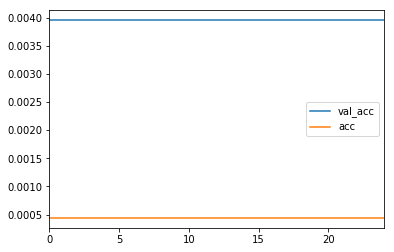

In [8]:
model_df[['val_acc','acc']].plot()

In [15]:
# Test the model accuracy on existing data
test_start = dt.datetime(2016,10,10)
test_end = dt.datetime.now()

test_data = web.DataReader(company,'yahoo',test_start,test_end)
actual_prices=test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']),axis=0)

model_inputs = total_dataset[len(total_dataset)-len(test_data)-prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

In [16]:
#Make Predictions on test data
x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices )

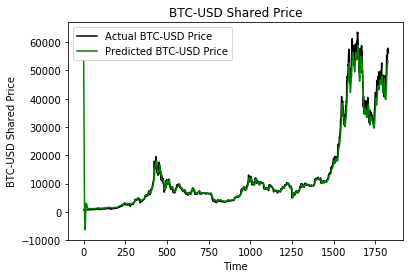

In [17]:
#Plot the test predictions
plt.plot(actual_prices, color='black', label = f'Actual {company} Price')
plt.plot(predicted_prices, color = 'green', label = f'Predicted {company} Price')
plt.title(f'{company} Shared Price')
plt.xlabel('Time')
plt.ylabel(f'{company} Shared Price')
plt.legend()
plt.show()

In [8]:
#Predict Next Day

real_data = [model_inputs[len(model_inputs)-prediction_days:len(model_inputs+1),0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1],1))

#print(scaler.inverse_transform(real_data[-1]))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f'Prediction: {prediction}')

Prediction: [[77.180435]]
